## Adversarial training on CIFAR-10

This is an additional experiment showing adversarial training of a ResNet-50 model for a Projected Gradient Descent (PGD) attack. The model is first trained on the CIFAR-10 data set.

In [8]:
import tensorflow as tf
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import neural_structured_learning as nsl
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
checkpoint_path = "../../data/models/cifar10.ckpt"
model = tf.keras.applications.ResNet50(classes = 10, weights = None, input_shape = x_train.shape[1:])
model.load_weights(checkpoint_path);
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy'])

In [5]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [6]:
y_train_cat = tf.keras.utils.to_categorical(y_train)
y_test_cat  = tf.keras.utils.to_categorical(y_test)

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.fit(x_train, y_train_cat, 
          validation_data=(x_test, y_test_cat),
          callbacks=[cp_callback],
          epochs = 1);

Next, we will generate an adversarial example.

In [9]:
adv_config = nsl.configs.make_adv_reg_config(multiplier=0.2, adv_step_size=0.05, pgd_epsilon=.05, pgd_iterations=10)
adv_model = nsl.keras.AdversarialRegularization(model, label_keys=['label'], adv_config=adv_config)
adv_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

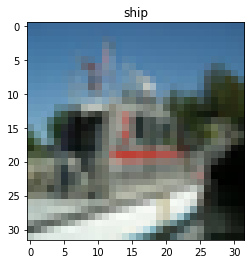

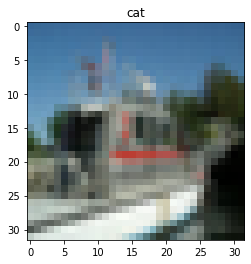

In [10]:
input_name = model.input_names[0]

tf.get_logger().setLevel('ERROR')
perturbed_example = adv_model.perturb_on_batch({input_name: x_test[600:601], 'label': y_test[600:601]}, 
                                               pgd_iterations = 100, pgd_epsilon=0.2)
perturbed_example[input_name] = tf.clip_by_value(perturbed_example[input_name], 0.0, 1.0)

fig = plt.figure();
ax = fig.gca()
ax.imshow(x_test[600:601][0]);
ax.set_title(classes[np.argmax(model.predict(x_test[600:601]))]);

fig = plt.figure();
ax = fig.gca()
ax.imshow(perturbed_example[input_name][0]);
ax.set_title(classes[np.argmax(model.predict(perturbed_example[input_name]))]);

In [ ]:
adv_trained_model = nsl.keras.AdversarialRegularization(model, label_keys=['label'], adv_config=adv_config)
adv_trained_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
adv_trained_model.fit({input_name: x_train, 'label': y_train}, epochs=1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x00000156938269A8> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


 527/1563 [=========>....................] - ETA: 6:56 - loss: 0.3330 - sparse_categorical_crossentropy: 0.2433 - sparse_categorical_accuracy: 0.9169 - scaled_adversarial_loss: 0.0897

In [ ]:
fig = plt.figure();
ax = fig.gca()
ax.imshow(x_test[600:601][0]);
ax.set_title(classes[np.argmax(adv_trained_model.base_model.predict(x_test[600:601]))]);

fig = plt.figure();
ax = fig.gca()
ax.imshow(perturbed_example[input_name][0]);
ax.set_title(classes[np.argmax(adv_trained_model.base_model.predict(perturbed_example[input_name]))]);

In [ ]:
adv_config2 = nsl.configs.make_adv_reg_config(multiplier=0.5, adv_step_size=0.5)
adv_model2 = nsl.keras.AdversarialRegularization(adv_trained_model.base_model, label_keys=['label'], adv_config=adv_config2)
adv_model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
perturbed_example2 = adv_model2.perturb_on_batch({input_name: x_test[600:601], 'label': y_test[600:601]}, 
        adv_step_size=0.01,
        adv_grad_norm='infinity',
        pgd_iterations=10,
        pgd_epsilon=.05)

In [ ]:
fig = plt.figure();
ax = fig.gca()
ax.imshow(x_test[600:601][0]);
ax.set_title(classes[np.argmax(adv_trained_model.base_model.predict(x_test[600:601]))]);

fig = plt.figure();
ax = fig.gca()
ax.imshow(perturbed_example2[input_name][0]);
ax.set_title(classes[np.argmax(adv_trained_model.base_model.predict(perturbed_example2[input_name]))]);